# Covid 19 : India Analysis and Forecasting

## Note: 
<p> The author doesn't claim to have any domain knowledge and isn't an epidemiologist. The analysis in this notebook is just an attempt to learn new techniques and gather potential insights from the available data but shouldn't be taken seriously. </p>

In [1129]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
from matplotlib import dates as dt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn')

# 1. Grabbing Data

### A. Using Kaggle Challenge Dataset 
Stored Locally.

In [2]:
path_train = 'covid19-global-forecasting-week-4/train.csv'
path_test = 'covid19-global-forecasting-week-4/test.csv'
path_sbumit = 'covid19-global-forecasting-week-2/submission.csv'

train_kaggle = '/kaggle/input/covid19-global-forecasting-week-2/train.csv'
test_kaggle = '/kaggle/input/covid19-global-forecasting-week-2/test.csv'
submit_kaggle = '/kaggle/input/covid19-global-forecasting-week-2/submission.csv'

path_graphs = 'Graphs/'

In [3]:
df_train_count = pd.read_csv(path_train)
df_test_count = pd.read_csv(path_test)
df_train_count.rename(columns = {'Country_Region': 'Country/Region', 'Province_State':'Province/State'}, inplace = True)
df_test_count.rename(columns = {'Country_Region': 'Country/Region', 'Province_State':'Province/State'}, inplace = True)

#### Helper Functions For Kaggle Dataset : 1. To filter DataFrame according to Country.

In [4]:
def country_df(country, df):
    """Filters a Dataframe according to Country.
    Args: 
    country: String. Name of country for which dataframe is to be filtered for.
    df: Dataframe. The Dataframe that is to be filtered.
    Returns: 
    df_cases: Dataframe. Filtered dataframe containing fields with confirmed Covid cases for the country.
    df_fatal: Dataframe. Filtered dataframe containing fileds with Covid fatalities for the country.
    """
    if country != 'World':
        country_filt = (df['Country/Region'] == country)
        df_cases = df.loc[country_filt].groupby(['Date'])['ConfirmedCases'].sum()
        df_fatal = df.loc[country_filt].groupby(['Date'])['Fatalities'].sum()
    else:
        df_cases = df.groupby(['Date'])['ConfirmedCases'].sum()
        df_fatal = df.groupby(['Date'])['Fatalities'].sum()
    
    return df_cases, df_fatal

#### 2. To Prepare Model Train data.

In [5]:
def prepare_train_data(df_cases, df_fatal):
    """Splits ConfirmedCases and Fatalities dataframe into training features and labels.
    Args:
    df_cases: Dataframe. Filtered dataframe containing fields with confirmed Covid cases for the country.
    df_fatal: Dataframe. Filtered dataframe containing fileds with Covid fatalities for the country.
    Returns:
    x_train: np array. Array of integers denoting days since firstday of original df for model training features.
    y_cases: List. List of Confirmed Cases as labels for model from first day of original df.
    y_fatal: List. List of Fatalities as labels for model from first day of original df.
    """
    x_train = np.arange(0, len(df_cases)).reshape(-1,1)
    y_cases = df_cases.to_list()
    y_fatal = df_fatal.to_list()
   
    
    return x_train, y_cases, y_fatal


#### 3. For Plotting Actual and Predicted Metrics after modelling.

In [1073]:
def plot_actual_predicted(country,label,  y_cases, y_pred, show_lockdown = False, start_date = '2020-01-22'):
    """Plots the Actual and Predicted ConfirmedCases/Fatalities for a country.
    Args:
    country(string) country name.
    y_cases, y_pred (array/list) - Actual And Predicted Metrics.
    label(string) - Which metric is being passed.
    Returns:
    """
        
    xtick_locator = AutoDateLocator()
    xtick_formatter = AutoDateFormatter(xtick_locator)
    
    # generating dates using pandas, can be used with date_plot.
    train_times = pd.date_range(start = start_date , periods=len(y_cases))
    test_times = pd.date_range(start = start_date, periods=len(y_pred))
    dates = train_times.to_series().dt.date
    dates_test = test_times.to_series().dt.date

    # converting to Series, list 
    d_train = dates.tolist()
    d_test  = dates_test.tolist()
    
    # getting date_format variable for matplotlib and lockdown date.
    date_format = dt.DateFormatter('%b, %d')
    
    # converting lockdown date string to datetime.
    lockdown_date_str = '2020-03-25'
    lockdown_date = datetime.datetime.strptime(lockdown_date_str, '%Y-%m-%d')
    
    plt.style.use('seaborn')
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(17)
    fig.autofmt_xdate()
    ax.plot_date(d_train , y_cases, label = 'Actual Values', linestyle = 'solid', marker = None)
    ax.plot_date(d_test , y_pred , label = 'Predicted Values', linestyle = 'solid', marker = None)
    ax.set_title(f'{country} : {label} - Ridge Regression (Degree = 3, alpha = 10.0)')
    ax.set_ylabel(f'No of {label}')
    if show_lockdown:
        ax.axvline(lockdown_date, color = 'r', label='Lockdown')
    ax.xaxis.set_major_formatter(date_format)
    ax.legend()
    #fig.savefig( path_graphs + f'{country}_conf_case.jpg')

### B. Getting Data Using Covid19India.org API
Fetches JSON from the Covid19.org API and creates dataframe of Daily and Total Cases, Recovered, Deceased.<br>
Testing data from Datameet ICMR backup JSON.

In [7]:
from india_API_data.Covid19_india_org_api import make_dataframe
from india_API_data.Covid19_india_org_api import get_test_dataframe

#### Helper Functions For API Data : 1. Plotting Metrics

In [8]:
def plot_daily(df, columns, save = False, log = False):
    """ Helper Function to Plot Current Metrics from API data.
    Args: 
    df (Dataframe) - Dataframe of API data create Using Make_dataframe.
    columns (List of column names)
    save(Bool) - Whether to save fig.
    Returns:
    """
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(16)
    plt.style.use('seaborn')
    plt.title('Daily Trends: India (From API)')
    plt.ylabel('No. Of Individuals')
    plt.xlabel('Date')
    fig.autofmt_xdate()
    for item in columns:
        plt.plot_date(x = df.index, y= df[item], label = item, linestyle = 'solid', marker = None)
    plt.legend()
    if save == True:
        fig.savefig(path_graphs + save + 'India_Cumulative_stats.png')
    if log == True:
        plt.yscale('log')
        plt.title('Daily Trends(Log): India (From API)')
    plt.show()

# 2. Visualizations & Analysis


## Logistic Curve or S- shaped Curve : Comparing Epidemic Behaviour
<p>From the 3blue1brown video, epidemics are observed to follow a logistic curve. The no. of infected rises exponentially and reaches an inflection point before gradually decreasing. This can be somewhat seen in China's Confirmed Cases plot.</p>
![Image of Sigmoid](https://wikimedia.org/api/rest_v1/media/math/render/svg/9e26947596d387d045be3baeb72c11270a065665)
Here x0 = the x value of the sigmoids midpoint. <br>
L = the curve's maximum value. <br>
k = the logistic growth rate or steepness of the curve.

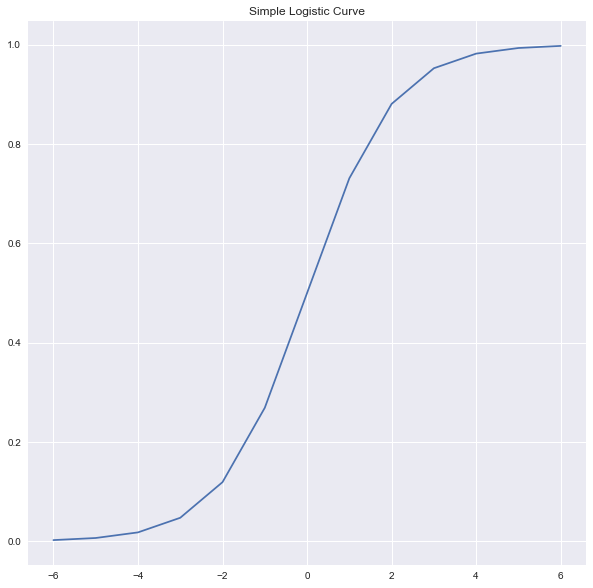

In [9]:
# Plotting a simple logistic curve using numpy and matplotlib.
# x = (-6,6), L =1, k = 1, x0 =0
x = np.arange(-6,7)
power = -1*x
y = 1 / (1 + np.exp(power))

plt.figure(figsize=(10,10))
plt.title('Simple Logistic Curve')
plt.grid(True)
plt.plot(x, y)
plt.show()

## This behaviour can be somewhat seen in the case of China

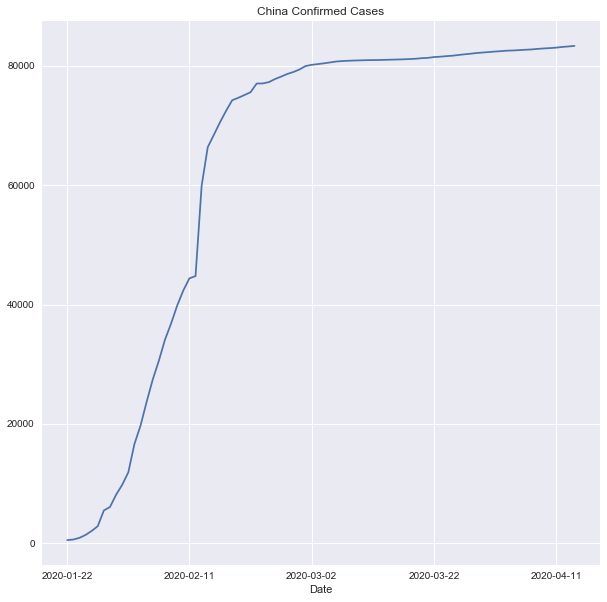

In [10]:
china_cases, china_fatal = country_df('China', df_train_count)
china_cases.plot(figsize = (10,10), title = 'China Confirmed Cases', grid = True)
plt.show()

## Worlwide Cases

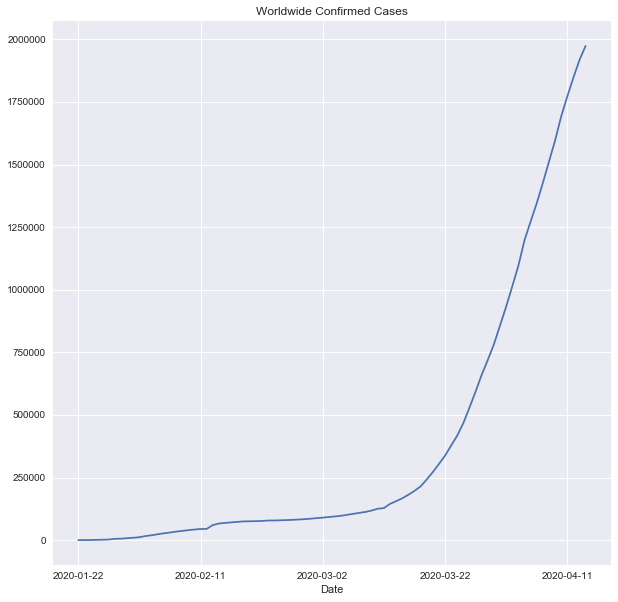

In [11]:
world_cases, world_fatal = country_df('World', df_train_count)
world_cases.plot(figsize = (10,10), title = 'Worldwide Confirmed Cases', grid = True)
plt.show()

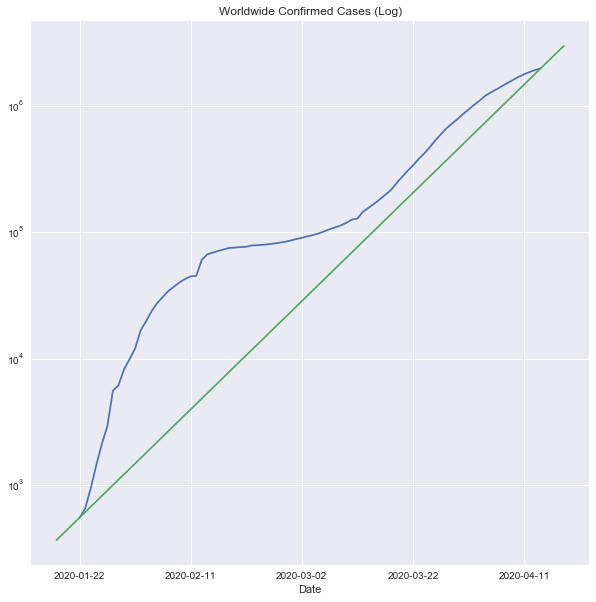

In [12]:
world_cases.plot(figsize = (10,10), title = 'Worldwide Confirmed Cases (Log)', grid = True, logy = True)
ax = plt.gca()
plt.plot([ax.get_xlim()[0],ax.get_xlim()[1]],[ax.get_ylim()[0],ax.get_ylim()[1]])
plt.show()

1. The Number of People getting infected is still growing, but to check whether it is growing exponentially we have to use the log scale.
2. The data plotted on the log Scale shows that the growth Seems to be touching the green line representing exponential growth. This could be a temporary Dip Before another wave and does not guarantee that the inflection point of the initial expoenential growth has been reached.

## India - Current Statistics

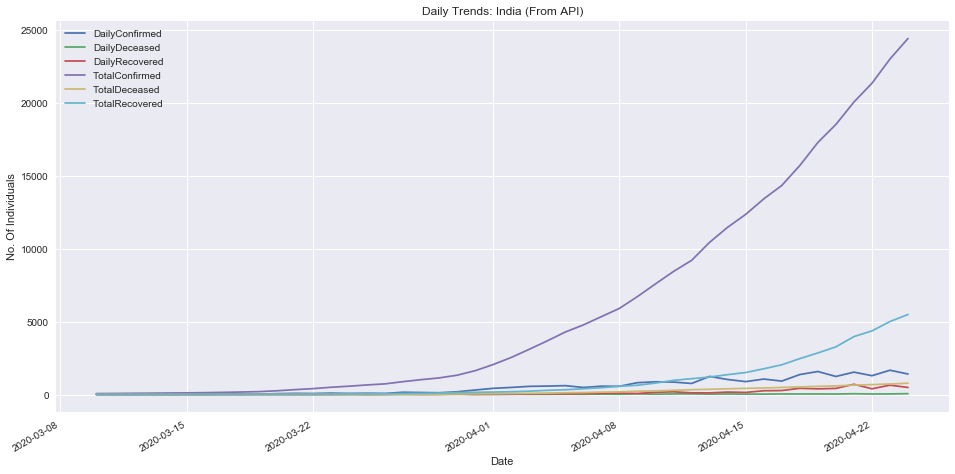

In [711]:
india_data = make_dataframe()
plot_daily(india_data.iloc[40:], india_data.columns.tolist(), save='All_stats_')

### India Testing Statistics
The comparison of the graphs of the amount of Testing Done and the confirmed Cases each day can be a good indicator of whether enough testing is being done. If the curves are very similar it can indicate that not enough people are getting tested.<br>
Looking at the comparison and observing the sharp increase in samples collected, we can say that testing is finally being done on a larger scale. (Testing Data from 03-13. Sharper increase in April)

In [14]:
india_test_df = get_test_dataframe()

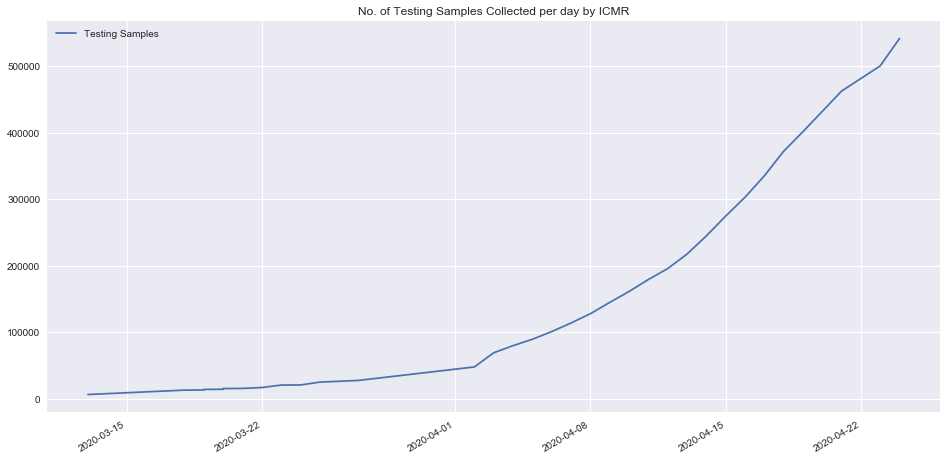

In [15]:
india_test_df.plot(title = 'No. of Testing Samples Collected per day by ICMR', figsize = (16,8))
plt.show()

In [16]:
# Combining with Statistics data
india_combined_data = india_test_df.join(india_data, how = 'right')

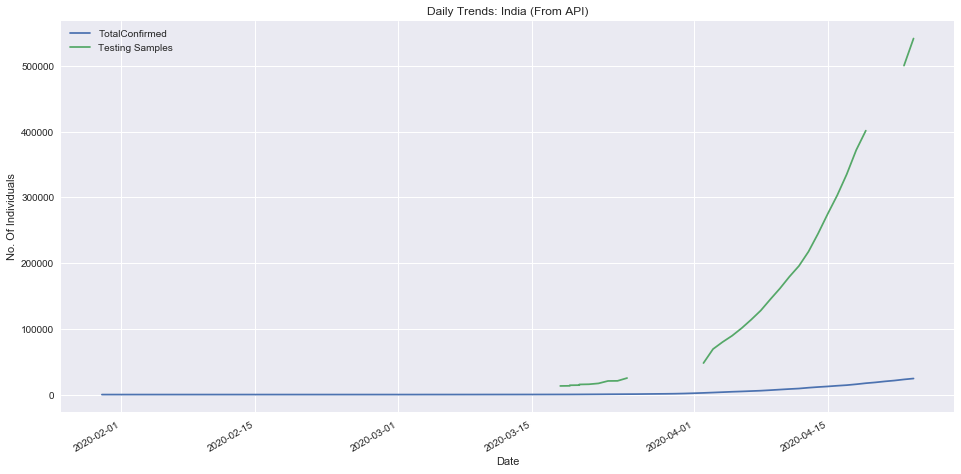

In [17]:
plot_daily(india_combined_data, ['TotalConfirmed', 'Testing Samples'])#, save='Cofirmed_testing_samples_')

### Growth Factor Of Virus
<p>
    The growth factor on day N is the number of confirmed cases on day N minus confirmed cases on day N-1 divided by the number of confirmed cases on day N-1 minus confirmed cases on day N-2.
     <br>Measure of whether the disease is growing or not. </p>
1. A value of greater than 1 = growth. <br>
2. Less than 1 = decline. <br>
3. A growth factor of 1 is the inflection point and at this point the disease is not increasing.

<p>
As of 24th April, it can be seen that the growth of the virus <b>hasn't stabilised at the inflection point</b>.<br>
The Linear Regression on the Growth Factor seems to point to a downward trend in the Growth Factor but the margin of error is high.

In [18]:
def growth_factor(confirmed):
    confirmed_nminus1 = confirmed.shift(1, axis = 0)
    confirmed_nminus2 = confirmed.shift(2, axis = 0)
    return ((confirmed - confirmed_nminus1)/(confirmed_nminus1 - confirmed_nminus2))

In [19]:
india_growth_factor = growth_factor(india_data.TotalConfirmed[41:])
print(f'Mean Growth Factor : {india_growth_factor.mean()}')

Mean Growth Factor : 1.1608722501849043


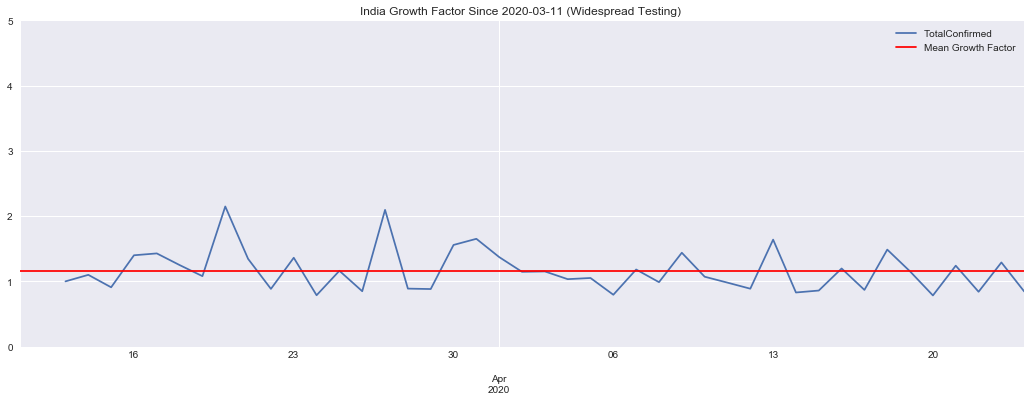

In [20]:
india_growth_factor.plot(grid = True, title = 'India Growth Factor Since 2020-03-11 (Widespread Testing) ', figsize = (18,6), ylim = (0,5))

plt.axhline(india_growth_factor.mean(), color = 'r', label='Mean Growth Factor')
plt.legend()
plt.savefig(path_graphs + 'India_Growth_Factor')
plt.show()

#### Linear Regression on Growth Factor.
This points to downwards trend, however due to not enough early testing there are outliers with very high growth rate. The confidence interval shows that a slight upwards curve is also possible, so the results need to be interpreted with caution. Removing the outliers resulted in a tighter confidence interval but have not been removed. Looking at the Residualplot, there appears to be a non-linear relationship between the growth factor and the time series of days since first case/data availability. This has been investigated later.

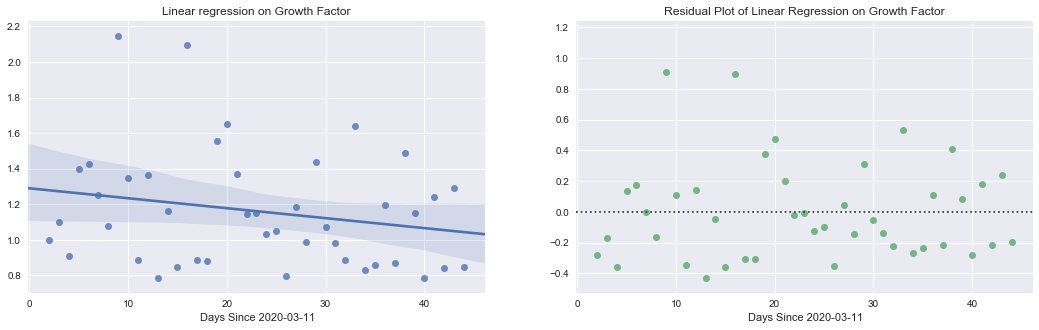

In [380]:
fig, ax = plt.subplots(1,2, figsize = (18,5))
sns.regplot(x = np.arange(len(india_growth_factor.index.tolist())) , y =india_growth_factor.to_list(), ax = ax[0])
ax[0].set_title('Linear regression on Growth Factor')
ax[0].set_xlabel(' Days Since 2020-03-11')
sns.residplot(x = np.arange(len(india_growth_factor.index.tolist())) , y =india_growth_factor.to_list(), ax =  ax[1] )
ax[1].set_title('Residual Plot of Linear Regression on Growth Factor')
ax[1].set_xlabel(' Days Since 2020-03-11')
#plt.savefig(path_graphs +'India_Growth_Factor_Pred')
plt.show()

### Growth Ratio of Virus
The growth ratio on day N is the number of confirmed cases on day N divided by the number of confirmed cases on day N-1.
Percentage Increase in total cumulative Cases from one day to the next. <br>
Looking at the graph, there is an unmistakable downward trend to the growth ratio, with a 6% growth in the number of cases occuring on the 24th April compared  to highs of 25-30% since the start of reliable testing. A linear relationship can be seen in the residualplot and appears to be a reasonable assumption.

 Mean growth Ratio of Cases In India : 1.1435493395010659


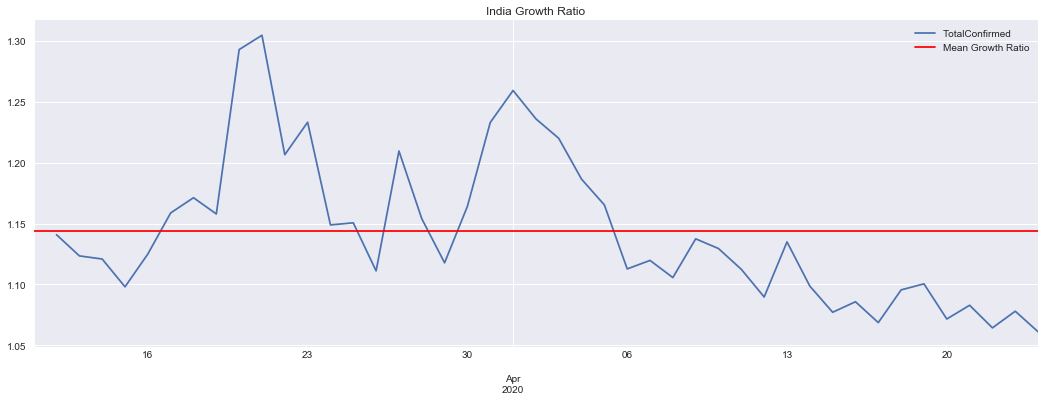

In [383]:
growth_ratio_india = india_data.TotalConfirmed[41:]/india_data.TotalConfirmed[41:].shift(1)
print(f' Mean growth Ratio of Cases In India : {growth_ratio_india.mean()}')
growth_ratio_india.plot(grid = True, title = 'India Growth Ratio', figsize = (18,6))
plt.axhline(growth_ratio_india.mean(), color = 'r', label='Mean Growth Ratio')
plt.legend()
#plt.savefig(path_graphs + 'India_Growth_Ratio')
plt.show()

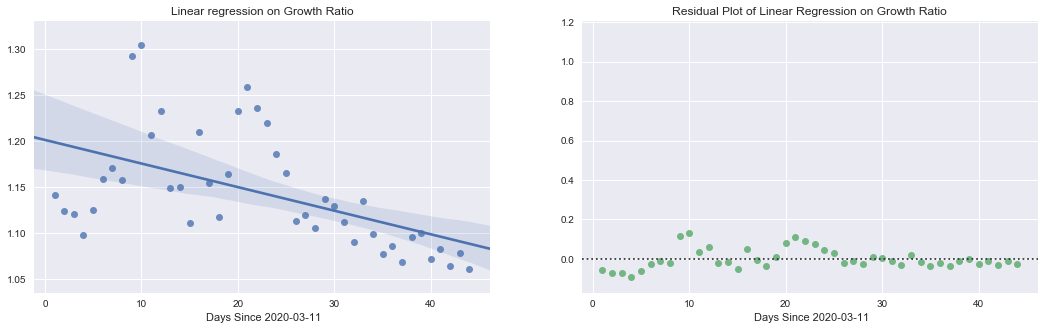

In [381]:
fig, ax = plt.subplots(1,2, figsize = (18,5))
sns.regplot(x = np.arange(len(growth_ratio_india.index.tolist())) , y =growth_ratio_india.to_list(), ax = ax[0])
ax[0].set_title('Linear regression on Growth Ratio')
ax[0].set_xlabel(' Days Since 2020-03-11')
sns.residplot(x = np.arange(len(growth_ratio_india.index.tolist())) , y =growth_ratio_india.to_list(), ax =  ax[1] )
ax[1].set_title('Residual Plot of Linear Regression on Growth Ratio')
ax[1].set_xlabel(' Days Since 2020-03-11')
#plt.savefig(path_graphs +'India_Growth_Factor_Pred')
plt.show()

# 3. Modeling - Regularized Ridge Regression
<p>Due to a scarcity of features, the results should be taken with a grain of salt and are heavilly influenced by the predictive power of the feature days since the outbreak .</p> First, the Growth factor and Growth Ratio are predicted for 'z' number of days using Ridge Regression. Ridge Regression applies half of the squared l2 norm of the weight vector as a regularization term or penalty to reduce overfitting and improve generalisation performance. This reduces in-sample training accuracy but will help the model generalise better in the absence of a large amount of features and training data.</p>
<p><b>Predictions: </b> The model has 80% in-sample accuracy and a MSE of 13631. Using the Model to Predict the Total Confirmed Cases upto September, we see a maximum or plateau of 140,000 confirmed Cases before the Total number of Active Cases starts to slow down around the middle of September.</p>

#### Growth Factor Predictions for the next 'z' Days

In [1111]:
z = 200

#### Linear Regression to get Predicted Growth Factor
<p>The parameters for the ridge regression were found using the best validation set score using gridsearchCV</p>

In [986]:
# X is just days from 03-10
# Target is the growth factor on these days
# First two values from GF is nan, so from 03-12 to Current day used for training

In [1112]:
# So, creating Features excluding first two days.
# x is days from 03-12
x = np.arange(1, len(india_growth_factor.to_list()[1:]))
y = india_growth_factor.to_list()[2:]

In [1113]:
pipe_gf = Pipeline([('poly', PolynomialFeatures(degree = 2)), ('scale', StandardScaler()),('ridge', Ridge(alpha = 5))])
x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1,1), y , test_size = .3, shuffle = False)
pipe_gf.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
                       normalize=False, random_state=None, solver='auto',
                       tol=0.001))],
         verbose=False)

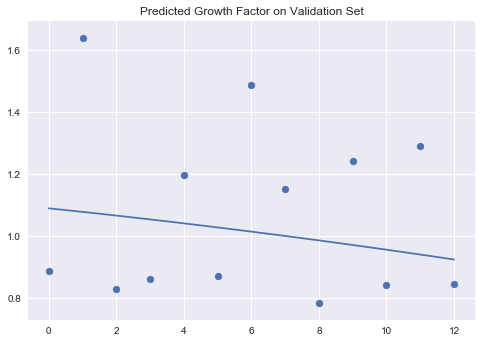

In [1114]:
plt.scatter(x =np.arange(0, len(x_test)) ,y = y_test)
plt.plot(pipe_gf.predict(x_test))
plt.title('Predicted Growth Factor on Validation Set')
plt.show()

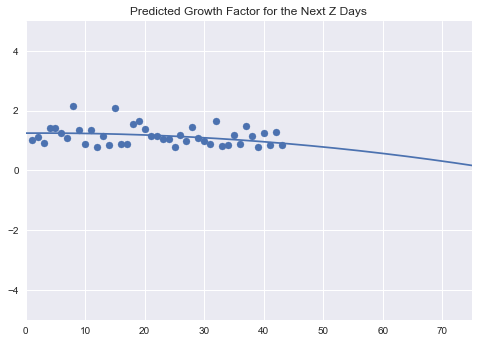

In [1115]:
plt.scatter(x, y)
plt.ylim(-5,5)
plt.xlim(0,75)
plt.plot(pipe_gf.predict(np.arange(1, len(x)+1+z ).reshape(-1,1)))
plt.title('Predicted Growth Factor for the Next Z Days')
plt.show()

In [1116]:
# Saving Predicted Grwoth Factor
y_gf_pred = pipe_gf.predict(np.arange(len(x)+1, len(x)+1+z).reshape(-1,1))

#### Linear Regression to get Predicted Growth Ratio
<p>The parameters for the ridge regression were found using the best validation set score using gridsearchCV</p>

In [1117]:
x = np.arange(1, len(growth_ratio_india.to_list()[1:]))
y_gr = growth_ratio_india.to_list()[2:]

In [1118]:
pipe_gr = Pipeline([('poly', PolynomialFeatures(degree = 2)), ('scale', StandardScaler()),('ridge', Ridge(alpha = 2))])
x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1,1), y_gr , test_size = .3, shuffle = False)
pipe_gr.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=2, copy_X=True, fit_intercept=True, max_iter=None,
                       normalize=False, random_state=None, solver='auto',
                       tol=0.001))],
         verbose=False)

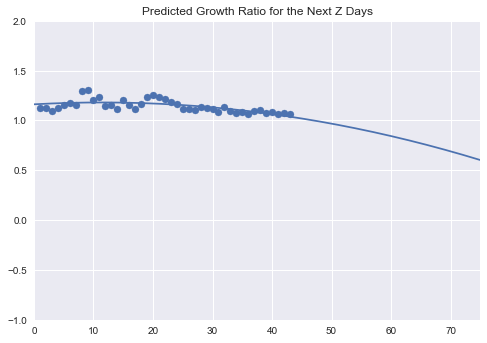

In [1119]:
plt.scatter(x, y_gr)
plt.ylim(-1,2)
plt.xlim(0,75)
plt.plot(pipe_gr.predict(np.arange(1,len(x)+1+z).reshape(-1,1)))
plt.title('Predicted Growth Ratio for the Next Z Days')
plt.show()

In [1120]:
# Saving These Predictions
y_gr_pred = pipe_gr.predict(np.arange(len(x)+1, len(x)+1+z).reshape(-1,1))

#### Storing Predicted Growth Factor and Ratio in Dataframe

In [1121]:
x_pre = pd.DataFrame(data = {'Days': np.arange(len(x)+1, len(x)+1+z), 'GrowthFactor': y_gf_pred, 'GrowthRatio': y_gr_pred })

### Preparing Training Data

####  Using Growth Factor as a feature

In [1122]:
# Imputing Missing values with mean of growth factor from 11-03 to present day.
# df_test_count.rename(columns = {'Country_Region': 'Country/Region', 'Province_State':'Province/State'}, inplace = True)
india_data = make_dataframe()
india_growth_factor_1 = growth_factor(india_data.TotalConfirmed[:])
india_growth_factor_1.replace(np.nan, india_growth_factor.mean(), inplace=True)
india_growth_factor_1.replace(np.inf, india_growth_factor.mean(), inplace = True)
india_growth_factor_1 = india_growth_factor_1.to_frame()
india_growth_factor_1.rename({'TotalConfirmed': 'GrowthFactor'}, axis=1, inplace=True)
# Merging the two dataframes
india_data = pd.concat([india_data, india_growth_factor_1], axis = 1)

####  Using Growth Ratio as a feature

In [1123]:
growth_ratio_india_1 = india_data.TotalConfirmed[:]/india_data.TotalConfirmed[:].shift(1)
growth_ratio_india_1.replace(np.nan, 1, inplace = True)
growth_ratio_india_1 = growth_ratio_india_1.to_frame()
growth_ratio_india_1.rename(columns = {'TotalConfirmed' : 'GrowthRatio'} , inplace=True)
#growth_ratio_india_1 = growth_ratio_india_1.to_frame()
growth_ratio_india_1.rename(columns = {'TotalConfirmed' : 'GrowthRatio'} , inplace=True)
# Merging the two dataframes
india_data = pd.concat([india_data, growth_ratio_india_1], axis = 1)

#### Train Data

In [1124]:
# Days since First case/data Availibity.
days_outb = np.arange(len(india_data))

india_data['Days'] = days_outb
x = india_data[['Days','GrowthFactor', 'GrowthRatio']]
y = india_data['TotalConfirmed']
# Not Shuffling time-Series Data.
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size = 0.3, shuffle = False)

## Predictions After Fitting Ridge Regression 
<p> Hyperparameters found using GridSearchCV :  Polynomial of Degree 3 and hyperparameter that controls the penalty, alpha = 10.</p>

In [1125]:
Input = [('poly', PolynomialFeatures(degree= 3)), ('scale', StandardScaler()), ('rid_reg', Ridge(alpha = 10))]

pipe= Pipeline(Input)
pipe.fit(x_train, y_train)
print(pipe.score(x_train, y_train))

0.8003581781051256


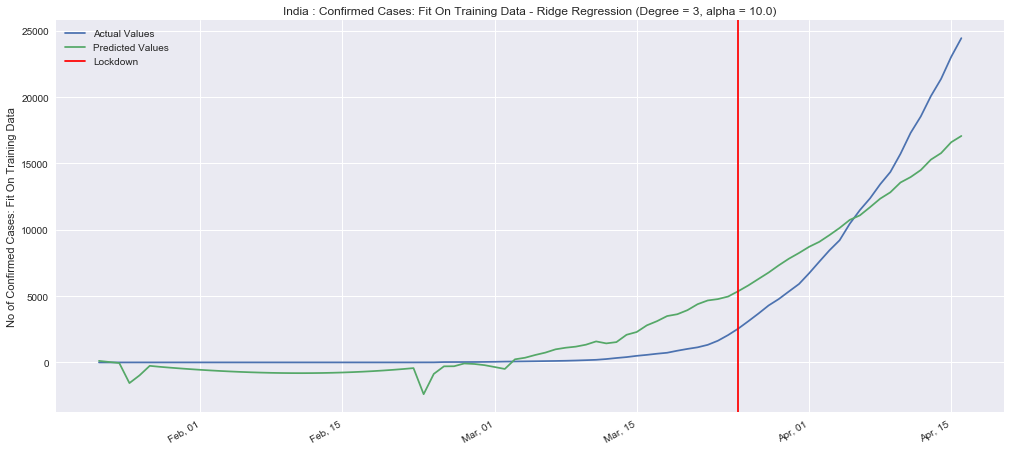

In [1126]:
pipe.fit(x, y)
predictions_train = pipe.predict(x)
predictions_z = pipe.predict(x_pre)
plot_actual_predicted('India', 'Confirmed Cases: Fit On Training Data', y, predictions_train, show_lockdown= True)

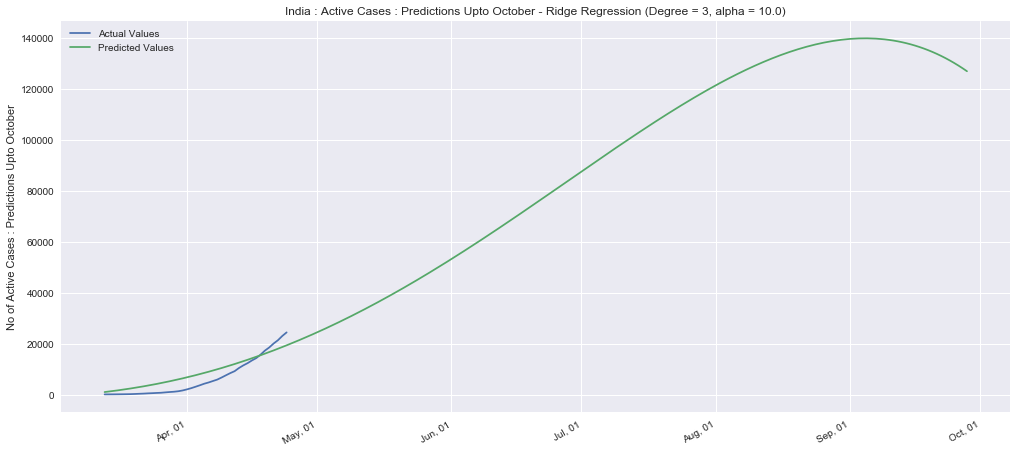

In [1128]:
plot_actual_predicted('India', 'Active Cases : Predictions Upto October', y[43:], predictions_z, show_lockdown= False, start_date = '2020-03-13')